[I 2025-07-02 05:43:17,376] A new study created in memory with name: no-name-29b305e3-09c6-45e8-887a-14d44f10aa42
I0000 00:00:1751434998.541525      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751434998.542236      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1751435008.080800     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
[I 2025-07-02 05:46:35,015] Trial 0 finished with value: 0.03697466785931713 and parameters: {'lstm_units1': 64, 'lstm_units2': 96, 'learning_rate': 0.0006636515983631631, 'dropout_rate': 0.1264021025638061, 'num_heads': 4}. Best is trial 0 with value: 0.03697466785931713.
[I 2025-07-02 05:49:20,930] Trial 1 finished with value: 0.038026740635838156 and parame

Best Hyperparameters: {'lstm_units1': 192, 'lstm_units2': 96, 'learning_rate': 0.0021160775664672282, 'dropout_rate': 0.27101687849274386, 'num_heads': 6}
Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.4342 - val_loss: 0.1325
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1382 - val_loss: 0.0900
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1171 - val_loss: 0.1141
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1205 - val_loss: 0.0877
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1063 - val_loss: 0.0727
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0991 - val_loss: 0.0594
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0786 - val_loss: 0.0668
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0811 - val_loss: 0.0447
Epoch 9/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0770 - val_loss: 0.0505
Epoch 10/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0867 - 

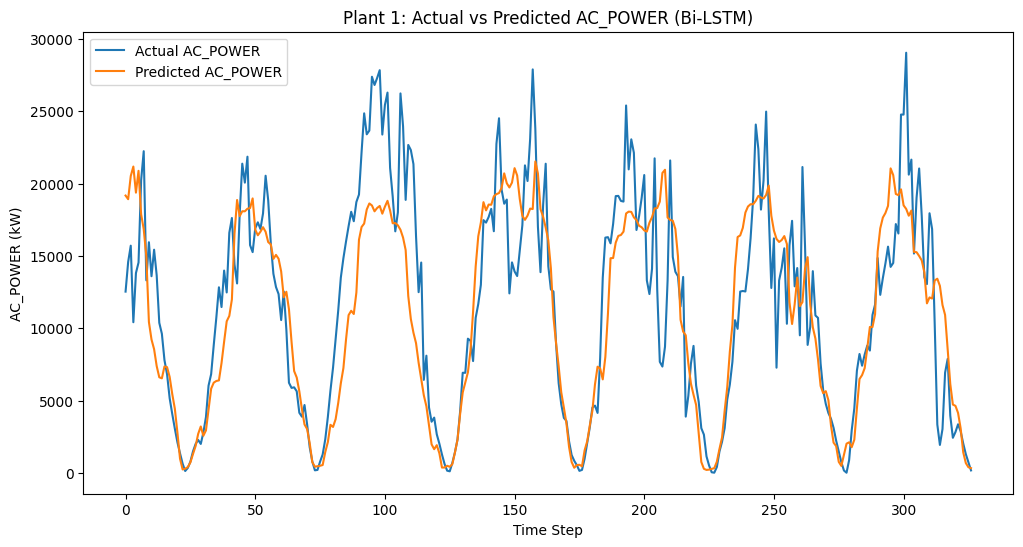

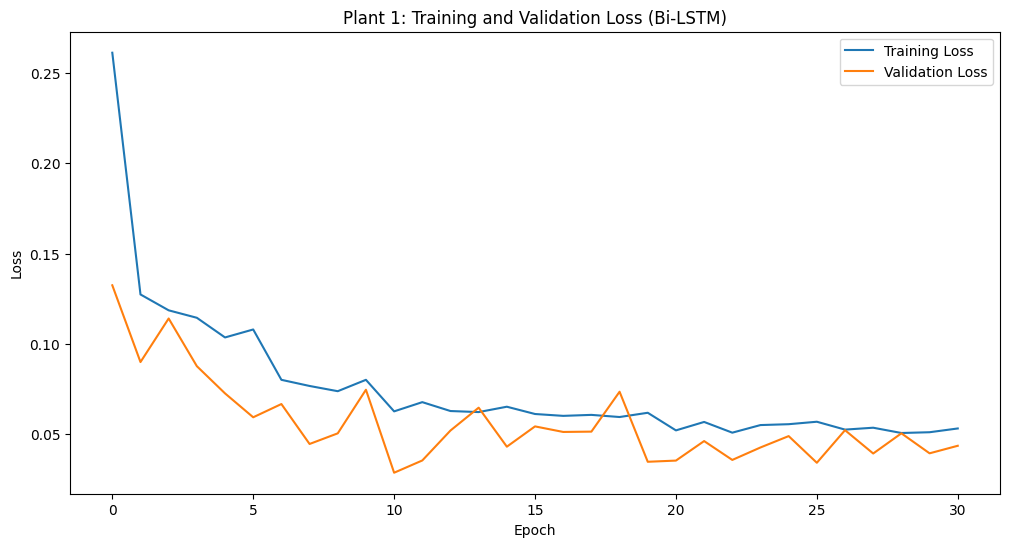

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import optuna
import matplotlib.pyplot as plt
import os

# Custom MAE loss function
def custom_mae_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

# Load and preprocess generation data
gen_data = pd.read_csv('/kaggle/input/solar-power-generation-and-weather-data/Plant1_filtered.csv')  # Adjust path
gen_data['DATE_TIME'] = pd.to_datetime(gen_data['DATE_TIME'], format='%d-%m-%Y %H:%M')

# Aggregate AC_POWER across inverters
gen_agg = gen_data.groupby('DATE_TIME')['AC_POWER'].sum().reset_index()
gen_agg.columns = ['DATE_TIME', 'total_AC_POWER']

# Load and preprocess weather data
weather_data = pd.read_csv('/kaggle/input/solar-power-generation-and-weather-data/Plant1_Weather_filtered.csv')  # Adjust path
weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'])

# Merge datasets
data = pd.merge(gen_agg, weather_data[['DATE_TIME', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']], 
                on='DATE_TIME', how='inner')

# Data cleaning: Remove missing values and outliers
data = data.dropna()
data = data[(data['total_AC_POWER'] >= 0) & (data['IRRADIATION'] >= 0)]  # Remove negative values
q1, q3 = data['total_AC_POWER'].quantile([0.25, 0.75])
iqr = q3 - q1
data = data[(data['total_AC_POWER'] >= q1 - 1.5 * iqr) & (data['total_AC_POWER'] <= q3 + 1.5 * iqr)]  # Remove outliers

# Log transformation for target
data['log_AC_POWER'] = np.log1p(data['total_AC_POWER'])

# Add lag features for weather variables and AC_POWER (2 hours = 8 lags)
for lag in range(1, 9):
    data[f'AMBIENT_TEMPERATURE_lag{lag}'] = data['AMBIENT_TEMPERATURE'].shift(lag)
    data[f'MODULE_TEMPERATURE_lag{lag}'] = data['MODULE_TEMPERATURE'].shift(lag)
    data[f'IRRADIATION_lag{lag}'] = data['IRRADIATION'].shift(lag)
    data[f'total_AC_POWER_lag{lag}'] = data['total_AC_POWER'].shift(lag)
data = data.dropna()

# Check for NaNs after lag creation
if data.isna().any().any():
    raise ValueError("NaN values found in data after lag creation")

# Add time features
data['hour'] = data['DATE_TIME'].dt.hour
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

# Add Fourier features
def generate_fourier_features(df, period, n_terms):
    df = df.copy()
    df['time_index'] = range(len(df))
    for i in range(1, n_terms + 1):
        df[f'sin_{i}'] = np.sin(2 * np.pi * i * df['time_index'] / period)
        df[f'cos_{i}'] = np.cos(2 * np.pi * i * df['time_index'] / period)
    df = df.drop(columns=['time_index'])
    return df

period = 96  # Daily periodicity for 15-minute intervals
n_terms = 25
data = generate_fourier_features(data, period, n_terms)

# Check for NaNs after Fourier features
if data.isna().any().any():
    raise ValueError("NaN values found in data after Fourier feature creation")

# Define features and target
features = ['log_AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION',
            'AMBIENT_TEMPERATURE_lag1', 'AMBIENT_TEMPERATURE_lag2', 'AMBIENT_TEMPERATURE_lag3', 'AMBIENT_TEMPERATURE_lag4',
            'AMBIENT_TEMPERATURE_lag5', 'AMBIENT_TEMPERATURE_lag6', 'AMBIENT_TEMPERATURE_lag7', 'AMBIENT_TEMPERATURE_lag8',
            'MODULE_TEMPERATURE_lag1', 'MODULE_TEMPERATURE_lag2', 'MODULE_TEMPERATURE_lag3', 'MODULE_TEMPERATURE_lag4',
            'MODULE_TEMPERATURE_lag5', 'MODULE_TEMPERATURE_lag6', 'MODULE_TEMPERATURE_lag7', 'MODULE_TEMPERATURE_lag8',
            'IRRADIATION_lag1', 'IRRADIATION_lag2', 'IRRADIATION_lag3', 'IRRADIATION_lag4',
            'IRRADIATION_lag5', 'IRRADIATION_lag6', 'IRRADIATION_lag7', 'IRRADIATION_lag8',
            'total_AC_POWER_lag1', 'total_AC_POWER_lag2', 'total_AC_POWER_lag3', 'total_AC_POWER_lag4',
            'total_AC_POWER_lag5', 'total_AC_POWER_lag6', 'total_AC_POWER_lag7', 'total_AC_POWER_lag8',
            'hour_sin', 'hour_cos'] + [f'sin_{i}' for i in range(1, n_terms + 1)] + [f'cos_{i}' for i in range(1, n_terms + 1)]
target = 'log_AC_POWER'

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])
scaled_df = pd.DataFrame(scaled_data, columns=features, index=data.index)
scaled_df['DATE_TIME'] = data['DATE_TIME']
scaled_df[target] = scaled_data[:, 0]

# Check for NaNs after scaling
if scaled_df[features].isna().any().any():
    raise ValueError("NaN values found in scaled data")

# Create sequences
def create_sequences(df, seq_length, target_col):
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df[features].iloc[i:i + seq_length].values)
        y.append(df[target_col].iloc[i + seq_length])
    X, y = np.array(X), np.array(y)
    # Check for NaNs in sequences
    if np.any(np.isnan(X)) or np.any(np.isnan(y)):
        raise ValueError("NaN values found in sequences")
    return X, y

seq_length = 48
X, y = create_sequences(scaled_df, seq_length, target)

# Hyperparameter tuning with Optuna
def objective(trial):
    # Define hyperparameter search space
    lstm_units1 = trial.suggest_int('lstm_units1', 64, 256, step=32)
    lstm_units2 = trial.suggest_int('lstm_units2', 32, 128, step=32)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4)
    num_heads = trial.suggest_int('num_heads', 2, 8, step=2)

    # Build model
    inputs = Input(shape=(seq_length, len(features)))
    x = Bidirectional(LSTM(lstm_units1, activation='tanh', return_sequences=True))(inputs)
    x = Dropout(dropout_rate)(x)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=64)(x, x)
    x = Dense(len(features))(x)
    x = LayerNormalization()(x + inputs)
    x = Bidirectional(LSTM(lstm_units2, activation='tanh'))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=custom_mae_loss)

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    val_mae = []
    for train_idx, val_idx in tscv.split(X):
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]
        y_train_cv, y_val_cv = y[train_idx], y[val_idx]
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        model.fit(X_train_cv, y_train_cv, epochs=50, batch_size=16, validation_data=(X_val_cv, y_val_cv),
                  callbacks=[early_stopping], verbose=0)
        y_pred_cv = model.predict(X_val_cv, verbose=0)
        # Clip predictions to avoid NaNs
        y_pred_cv = np.clip(y_pred_cv, -1e10, 1e10)
        if np.any(np.isnan(y_pred_cv)) or np.any(np.isnan(y_val_cv)):
            return float('inf')  # Skip trial if NaNs are present
        mae_cv = mean_absolute_error(y_val_cv, y_pred_cv)
        val_mae.append(mae_cv)
    
    return np.mean(val_mae)

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Get best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train final model with best hyperparameters
inputs = Input(shape=(seq_length, len(features)))
x = Bidirectional(LSTM(best_params['lstm_units1'], activation='tanh', return_sequences=True))(inputs)
x = Dropout(best_params['dropout_rate'])(x)
x = MultiHeadAttention(num_heads=best_params['num_heads'], key_dim=64)(x, x)
x = Dense(len(features))(x)
x = LayerNormalization()(x + inputs)
x = Bidirectional(LSTM(best_params['lstm_units2'], activation='tanh'))(x)
x = Dropout(best_params['dropout_rate'])(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']), loss=custom_mae_loss)

# Final train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train final model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.1,
                    callbacks=[early_stopping], verbose=1)

# Predict
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, -1e10, 1e10)  # Prevent NaNs in predictions

# Inverse scale predictions
y_test_rescaled = np.expm1(scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), len(features)-1))], axis=1))[:, 0])
y_pred_rescaled = np.expm1(scaler.inverse_transform(np.concatenate([y_pred, np.zeros((len(y_pred), len(features)-1))], axis=1))[:, 0])

# Evaluate on original scale
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / (y_test_rescaled + 1e-10))) * 100
print(f'Plant 1 - Bi-LSTM with Fourier (Original Scale) - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%')

# Evaluate on normalized scale
mae_normalized = mean_absolute_error(y_test, y_pred)
rmse_normalized = np.sqrt(mean_squared_error(y_test, y_pred))
mape_normalized = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-10))) * 100
print(f'Plant 1 - Bi-LSTM with Fourier (Normalized Scale) - MAE: {mae_normalized:.4f}, RMSE: {rmse_normalized:.4f}, MAPE: {mape_normalized:.4f}%')

# Persistence baseline
persistence_pred = np.expm1(scaler.inverse_transform(np.concatenate([y_test[:-1].reshape(-1, 1), np.zeros((len(y_test)-1, len(features)-1))], axis=1))[:, 0])
persistence_mae = mean_absolute_error(y_test_rescaled[1:], persistence_pred)
persistence_rmse = np.sqrt(mean_squared_error(y_test_rescaled[1:], persistence_pred))
persistence_mape = np.mean(np.abs((y_test_rescaled[1:] - persistence_pred) / (y_test_rescaled[1:] + 1e-10))) * 100
print(f'Plant 1 - Persistence (Original Scale) - MAE: {persistence_mae:.4f}, RMSE: {persistence_rmse:.4f}, MAPE: {persistence_mape:.4f}%')

# Compare with statistical benchmarks
benchmarks = {
    'Autoregressor': 0.085,
    'DES': 0.229,
    'GM(1,1)': 0.0806,
    'GM(1,1) with Fourier': 0.000
}
print("\nStatistical Benchmarks (Assumed Normalized Scale):")
for model_name, mae_value in benchmarks.items():
    print(f"{model_name} - MAE: {mae_value:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual AC_POWER')
plt.plot(y_pred_rescaled, label='Predicted AC_POWER')
plt.title('Plant 1: Actual vs Predicted AC_POWER (Bi-LSTM)')
plt.xlabel('Time Step')
plt.ylabel('AC_POWER (kW)')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Plant 1: Training and Validation Loss (Bi-LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save model with overwrite
model_file = 'plant1_bilstm_fourier_model.h5'
if os.path.exists(model_file):
    os.remove(model_file)
model.save(model_file)